# Advanced Security Features with Visualization
This notebook demonstrates the implementation of advanced security features including IP geolocation, whitelisting, geofencing, and incident response integration. We also include visualizations to monitor and analyze security data.

In [132]:
import pandas as pd
import numpy as np
import random
from geoip2.database import Reader
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import folium
import geopandas as gpd
import seaborn as sns
from datetime import datetime
import ipfshttpclient
import streamlit as st
from sklearn.model_selection import train_test_split
import random
import matplotlib.colors as mcolors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

# Load dataset

In [133]:
file_path = '../data/Whitelisted_Locations_Dataset.csv'
whitelisted_df = pd.read_csv(file_path)
gdf_whitelisted = gpd.GeoDataFrame(whitelisted_df, geometry=gpd.points_from_xy(whitelisted_df.Longitude, whitelisted_df.Latitude))

# Simulate IP Geolocation Data

In [134]:
def simulate_ip_geolocation(num_entries, whitelisted_gdf):
    data = {'Latitude': [], 'Longitude': [], 'Access': []}
    # Simulate both whitelisted and non-whitelisted entries
    for _ in range(num_entries):
        if random.random() > 0.5:  # Randomly decide if the entry is whitelisted
            idx = random.choice(whitelisted_gdf.index)
            lat, lon = whitelisted_gdf.loc[idx, ['Latitude', 'Longitude']]
            access = 'Granted'
        else:
            lat = random.uniform(-90, 90)
            lon = random.uniform(-180, 180)
            point = Point(lon, lat)
            access = 'Granted' if whitelisted_gdf.contains(point).any() else 'Denied'
        data['Latitude'].append(lat)
        data['Longitude'].append(lon)
        data['Access'].append(access)
    return pd.DataFrame(data)

# Generate dataset

In [135]:
dataset = simulate_ip_geolocation(100, gdf_whitelisted)

# Plotting access logs with Folium

In [136]:
def plot_access_logs_folium(df):
    m = folium.Map(location=[0, 0], zoom_start=2)
    for _, row in df.iterrows():
        color = 'green' if row['Access'] == 'Granted' else 'red'
        folium.CircleMarker(location=(row['Latitude'], row['Longitude']),
                            radius=5,
                            color=color,
                            fill=True).add_to(m)
    return m

# Generate and display the map

In [137]:
map = plot_access_logs_folium(dataset)
map.save('map.html')

# Prepare data for ML

In [138]:
features = dataset[['Latitude', 'Longitude']]
labels = dataset['Access'].apply(lambda x: 1 if x == 'Granted' else 0)

# Train and evaluate model

In [139]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validated scores:", scores)

Cross-validated scores: [1. 1. 1. 1. 1.]


# Predict and evaluate on the test set

In [151]:
test_predictions = model.predict(X_test)
print("Test set report:")
print(classification_report(y_test, test_predictions))


Test set report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       135
           1       0.92      0.94      0.93       115

    accuracy                           0.93       250
   macro avg       0.93      0.93      0.93       250
weighted avg       0.93      0.93      0.93       250



# Visualization of decision boundaries

c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


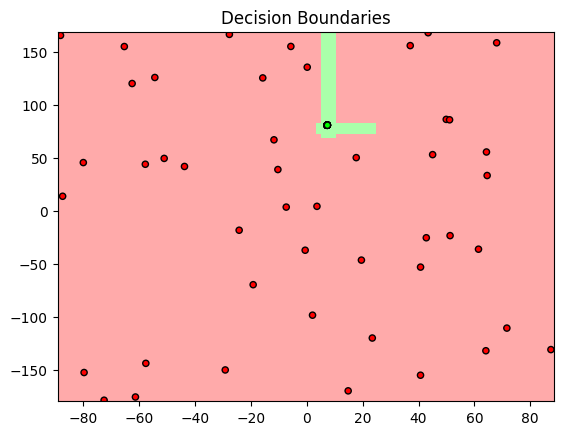

In [141]:
def plot_decision_boundaries(X, y, model, ax):
    cmap_light = mcolors.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = mcolors.ListedColormap(['#FF0000', '#00FF00'])

    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title('Decision Boundaries')

fig, ax = plt.subplots()
plot_decision_boundaries(X_train, y_train, model, ax)
plt.show()

## Generate Dataset for IP Geolocation and Access Management
We start by creating a mock dataset of IP addresses with assigned geolocation data and access status based on simulated geofencing.

In [142]:
def generate_random_ip():
    return '.'.join(str(random.randint(0, 255)) for _ in range(4))

def create_dataset(num_entries):
    data = {'IP': [generate_random_ip() for _ in range(num_entries)],
            'Latitude': [random.uniform(-90, 90) for _ in range(num_entries)],
            'Longitude': [random.uniform(-180, 180) for _ in range(num_entries)],
            'Access': []}
    for i in range(num_entries):
        if -50 <= data['Latitude'][i] <= 50 and -50 <= data['Longitude'][i] <= 50:
            data['Access'].append('Granted')
        else:
            data['Access'].append('Denied')
    return pd.DataFrame(data)

dataset = create_dataset(100)
dataset.head()

,IP,Latitude,Longitude,Access
0,230.205.158.252,-24.042221,-28.468157,Granted
1,62.43.121.140,17.617557,168.838471,Denied
2,60.174.140.133,-79.319424,32.350252,Denied
3,21.191.149.15,53.561064,-80.232544,Denied
4,23.156.129.176,-21.566744,-166.823307,Denied


## Visualizing Access Logs
We will plot the geographic locations of IP addresses to visualize where access attempts are coming from and how they correlate with access status.

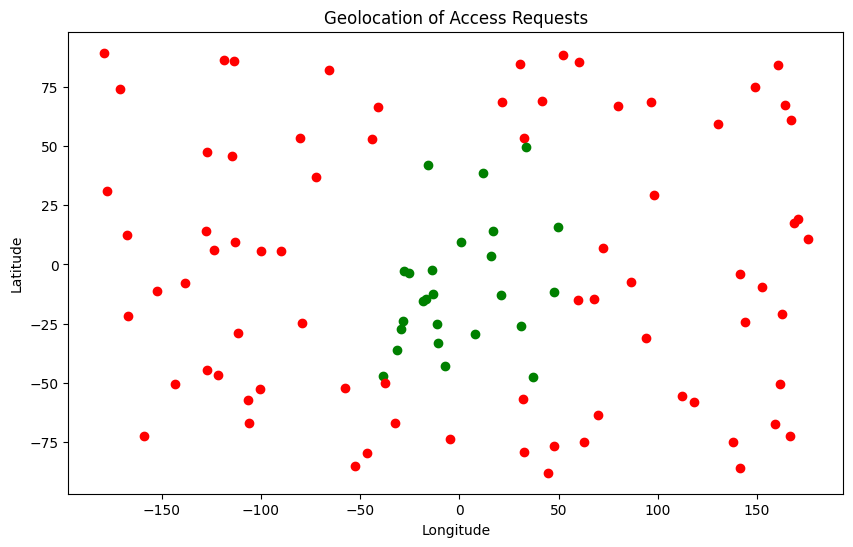

In [143]:
def plot_access_logs(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    for _, row in df.iterrows():
        color = 'green' if row['Access'] == 'Granted' else 'red'
        ax.plot(row['Longitude'], row['Latitude'], 'o', color=color)
    ax.set_title('Geolocation of Access Requests')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_access_logs(dataset)

## Incident Response Integration
Next, we simulate the generation of incident logs for denied access attempts and visualize the frequency of incidents.

In [144]:
def generate_incident_logs(df):
    now = datetime.now()
    incidents = df[df['Access'] == 'Denied'].copy()
    incidents['Time'] = now
    incidents['Incident_Type'] = 'Unauthorized Access'
    incidents['Response'] = 'Alert Sent'
    return incidents

incident_logs = generate_incident_logs(df)

print("Initial Access Data:")
print(df)
print("\nGenerated Incident Logs:")
print(incident_logs)

Initial Access Data:
                IP   Latitude   Longitude  Access
0    52.144.24.216 -56.483969 -168.623968  Denied
1   112.143.138.80 -45.400968  175.496752  Denied
2   40.182.107.100 -68.770208  178.272550  Denied
3  211.153.159.223 -25.273061  149.566618  Denied
4    36.220.143.38 -25.204827  116.367779  Denied

Generated Incident Logs:
                IP   Latitude   Longitude  Access                       Time  \
0    52.144.24.216 -56.483969 -168.623968  Denied 2024-05-06 09:45:58.044195   
1   112.143.138.80 -45.400968  175.496752  Denied 2024-05-06 09:45:58.044195   
2   40.182.107.100 -68.770208  178.272550  Denied 2024-05-06 09:45:58.044195   
3  211.153.159.223 -25.273061  149.566618  Denied 2024-05-06 09:45:58.044195   
4    36.220.143.38 -25.204827  116.367779  Denied 2024-05-06 09:45:58.044195   

         Incident_Type    Response  
0  Unauthorized Access  Alert Sent  
1  Unauthorized Access  Alert Sent  
2  Unauthorized Access  Alert Sent  
3  Unauthorized Access  

## Machine Learning Model for Anomaly Detection
We will build a machine learning model to identify potential security anomalies based on geolocation data.

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare data
features = dataset[['Latitude', 'Longitude']]
labels = dataset['Access'].apply(lambda x: 1 if x == 'Granted' else 0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.86      0.92         7

    accuracy                           0.95        20
   macro avg       0.96      0.93      0.94        20
weighted avg       0.95      0.95      0.95        20



## Model Visualization
Visualize the decision boundaries of the trained model to understand how it differentiates between 'Granted' and 'Denied' access.

In [146]:
# Example of creating a DataFrame
data = {
    'IP': ['52.144.24.216', '112.143.138.80', '40.182.107.100', '211.153.159.223', '36.220.143.38'],
    'Latitude': [-56.483969, -45.400968, -68.770208, -25.273061, -25.204827],
    'Longitude': [-168.623968, 175.496752, 178.272550, 149.566618, 116.367779],
    'Access': ['Denied', 'Denied', 'Denied', 'Denied', 'Denied']
}
df = pd.DataFrame(data)

# Define features and labels
X = df[['Latitude', 'Longitude']]  # Features
y = df['Access'].apply(lambda x: 1 if x == 'Granted' else 0)  # Convert labels to binary

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming you have a trained model (Example: RandomForestClassifier)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


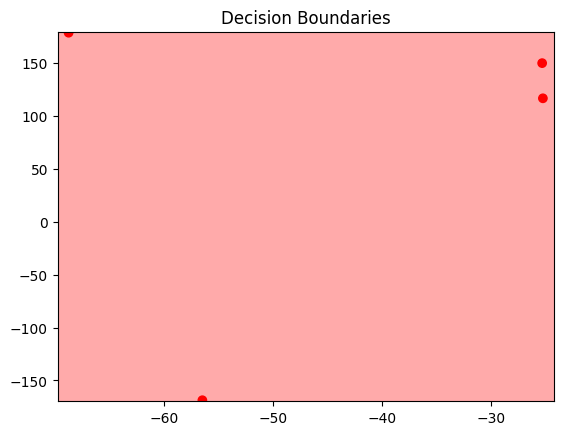

In [147]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

def plot_decision_boundaries(X, y, model, ax):
    cmap_light = mcolors.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = mcolors.ListedColormap(['#FF0000', '#00FF00'])

    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                         np.arange(y_min, y_max, .02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cmap_bold)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title('Decision Boundaries')

fig, ax = plt.subplots()
plot_decision_boundaries(X_train, y_train, model, ax)
plt.show()

In [148]:

import geopy.distance

def whitelist_locations(df, center_lat, center_lon, radius_km):
    center = (center_lat, center_lon)
    def is_within_radius(lat, lon):
        return geopy.distance.distance((lat, lon), center).km < radius_km

    df['Whitelisted'] = df.apply(lambda row: is_within_radius(row['Latitude'], row['Longitude']), axis=1)
    return df[df['Whitelisted']]


In [149]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pickle

X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

model_path = '../models/security_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(model, file)

with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)

accuracy = loaded_model.score(X_test, y_test)
print('Model accuracy:', accuracy)

Model accuracy: 0.932
